# 4. Mooney Reconstruction

In [20]:
import numpy as np
import scipy
import pickle
import cv2
from scipy.linalg import eig
from scipy.linalg import sqrtm
from numpy.linalg import inv
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from IPython.display import Image, display

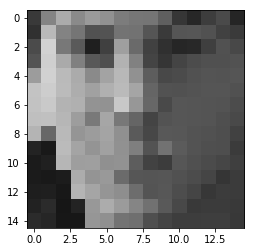

(956, 675)


In [21]:
file = open('./hw5_data/x_train.p', 'rb')
x_train=pickle.load(file, encoding='latin1')
file.close()
file = open('./hw5_data/x_test.p', 'rb')
x_test=pickle.load(file, encoding='latin1')
file.close()
file = open('./hw5_data/y_train.p', 'rb')
y_train=pickle.load(file, encoding='latin1')
file.close()
file = open('./hw5_data/y_test.p', 'rb')
y_test=pickle.load(file, encoding='latin1')
file.close()

x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

plt.imshow(y_train[0]/255)
plt.show()

x_trainf=np.zeros((len(x_train),15*15*3))
y_trainf=np.zeros((len(x_train),15*15*3))
x_testf=np.zeros((len(x_test),15*15*3))
y_testf=np.zeros((len(x_test),15*15*3))

for j in range(0,len(x_train)):
    x_trainf[j]=x_train[j].flatten()
    y_trainf[j]=y_train[j].flatten()

for j in range(0,len(x_test)):
    x_testf[j]=x_test[j].flatten()
    y_testf[j]=y_test[j].flatten()
    
x_trainf=(x_trainf/255)*2.0-1.0
x_testf=(x_testf/255)*2.0-1.0
y_trainf=(y_trainf/255)*2.0-1.0
y_testf=(y_testf/255)*2.0-1.0

print(x_trainf.shape)
# print(x_trainf[0])
# print(x_train[0])

Part A: Estimate the 3 covariance matrices

In [3]:
n=len(x_trainf)
m=15*15*3

# first find the sample mean
x_mean=np.zeros((1,m))
y_mean=np.zeros((1,m))
for i in range(0,n):
    x_mean=x_mean+x_trainf[i]
    y_mean=y_mean+y_trainf[i]
x_mean=x_mean/n
y_mean=y_mean/n

# print(x_mean.shape)

# estimate covariance repeat through dimensions
est_xx=np.zeros((m,m))
est_yy=np.zeros((m,m))
est_xy=np.zeros((m,m))

for i in range(0,n):
    sampx=x_trainf[i,:]-x_mean
    sampy=y_trainf[i,:]-y_mean
    est_xx=est_xx+np.dot(np.matrix.transpose(sampx),sampx)
    est_yy=est_yy+np.dot(np.matrix.transpose(sampy),sampy)
    est_xy=est_xy+np.dot(np.matrix.transpose(sampx),sampy)
    
est_xx=est_xx/(n-1)
est_yy=est_yy/(n-1)
est_xy=est_xy/(n-1)

# print(est_xx[:,:,0])

Part B: Plot the spectrum of singular values of the matrix in the optimization

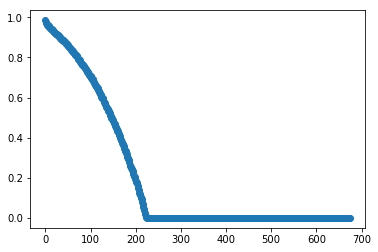

In [4]:
lam=0.00001
est_xxr=est_xx+lam*np.identity(m)
est_yyr=est_yy+lam*np.identity(m)

M=np.dot(scipy.linalg.sqrtm(np.linalg.inv(est_xxr)),np.dot(est_xy,scipy.linalg.sqrtm(np.linalg.inv(est_yyr))))
# M=np.dot(np.linalg.inv(scipy.linalg.sqrtm((est_xxr))),np.dot(est_xy,np.linalg.inv(scipy.linalg.sqrtm(est_yyr))))
U, s, V=np.linalg.svd(M)
# print(s)
p=len(s)
pl=np.arange(0,p,1)
plt.figure(3)
plt.plot(pl,s,"o")
plt.show(3)

Part C: Visualize the face corresponding to the first eigenvector u0

C:\Users\laura_brink\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


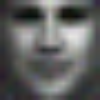

In [95]:
u0 = U[0]
u0_adj=u0+x_mean
plot_image(u0_adj)
display(Image("eigen_face.png"))

In [18]:
def plot_image(vector):
    vector = ((vector+1.0)/2.0)*255.0
    vector = np.reshape(vector,(15,15,3))
    p=vector.astype("uint8")
    p=cv2.resize(p,(100,100))
    count=0
    cv2.imwrite('eigen_face.png',p)

Part D: Implement Ridge Regression

C:\Users\laura_brink\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


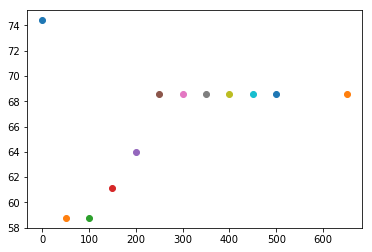

[ 74.40355042  58.77477025  58.80340593  61.10946444  63.97084902
  68.6081441   68.60817165  68.6081752   68.6081766   68.60817751
  68.60817829  68.60817954]


In [56]:
lam=0.00001
kl=[0,50,100,150,200,250,300,350,400,450,500,650]
test_error=np.zeros(len(kl))

plt.figure(5)
for j in range(0,len(kl)):

    k=kl[j]
    # construct the matrix P, size(675, k)
    # X is size (#samples,675)
    # Y is size (#samples,675)
    P=np.zeros((m,k))
    for i in range(0,k):
        P[:,i]=U[i]
#     print(k)
#     print(P.shape)
    w=np.zeros((k,m))
    # from ridge regression, w=(M.TM+lamI)^-1M.TY
    M=np.dot(x_trainf-x_mean,P)
    np.dot(M.T,M).shape
    M_ridge=np.dot(M.T,M)+lam*np.identity(k)
    w=np.dot(np.dot(np.linalg.inv(M_ridge),M.T),y_trainf-y_mean)

    # plot the squared euclidian test error
    # ||PkT*X_test*w - Y_test||2^2
    test_error[j]=np.linalg.norm((np.dot(x_testf-x_mean,np.dot(P,w)))-(y_testf-y_mean),2)
    
    plt.plot(k,test_error[j],"o")
    
plt.show(5)
print(test_error)


Part E: Run the learned model on 4 of the images in the test set

In [75]:
lam=0.00001

k=100
# construct the matrix P, size(675, k)
# X is size (#samples,675)
# Y is size (#samples,675)
P=np.zeros((m,k))
for i in range(0,k):
    P[:,i]=U[i]
#     print(k)
#     print(P.shape)
w=np.zeros((k,m))
# from ridge regression, w=(M.TM+lamI)^-1M.TY
M=np.dot(x_trainf-x_mean,P)
np.dot(M.T,M).shape
M_ridge=np.dot(M.T,M)+lam*np.identity(k)
w=np.dot(np.dot(np.linalg.inv(M_ridge),M.T),y_trainf-y_mean)

def plot_image1(vector,name):
    vector = ((vector+1.0)/2.0)*255.0
    vector = np.reshape(vector,(15,15,3))
    p=vector.astype("uint8")
    p=cv2.resize(p,(100,100))
    count=0
    cv2.imwrite(name,p)



C:\Users\laura_brink\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


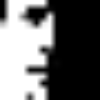

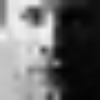

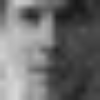

In [89]:
x_trial=x_testf[0]
binary=x_testf[0]
gray=y_testf[0]
output=np.dot(x_trial-x_mean,np.dot(P,w))+y_mean
plot_image1(binary,name='test_1_binary.png')
plot_image1(gray,name='test_1_grayscale.png')
plot_image1(output,name='test_1_output.png')

display(Image("test_1_binary.png"))
display(Image("test_1_grayscale.png"))
display(Image("test_1_output.png"))

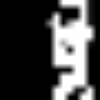

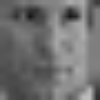

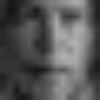

In [90]:

x_trial=x_testf[1]
binary=x_testf[1]
gray=y_testf[1]
output=np.dot(x_trial-x_mean,np.dot(P,w))+y_mean
plot_image1(binary,name='test_2_binary.png')
plot_image1(gray,name='test_2_grayscale.png')
plot_image1(output,name='test_2_output.png')

display(Image("test_2_binary.png"))
display(Image("test_2_grayscale.png"))
display(Image("test_2_output.png"))


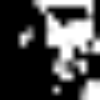

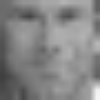

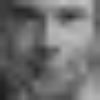

In [94]:
x_trial=x_testf[8]
binary=x_testf[8]
gray=y_testf[8]
output=np.dot(x_trial-x_mean,np.dot(P,w))+y_mean
plot_image1(binary,name='test_3_binary.png')
plot_image1(gray,name='test_3_grayscale.png')
plot_image1(output,name='test_3_output.png')

display(Image("test_3_binary.png"))
display(Image("test_3_grayscale.png"))
display(Image("test_3_output.png"))

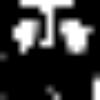

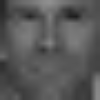

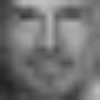

In [92]:
x_trial=x_testf[3]
binary=x_testf[3]
gray=y_testf[3]
output=np.dot(x_trial-x_mean,np.dot(P,w))+y_mean
plot_image1(binary,name='test_4_binary.png')
plot_image1(gray,name='test_4_grayscale.png')
plot_image1(output,name='test_4_output.png')


display(Image("test_4_binary.png"))
display(Image("test_4_grayscale.png"))
display(Image("test_4_output.png"))